<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/exponential_smoothing_and_static_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exponential smoothing and static maps
In this exercise we will try to craft different flavours of exponential smoothing algorithms from scratch, and compare their performance. Recalling that the exponential smoothing forecasters have a state space form, we will also try to compare them with static maps, such as linear regression on the time series embedding. 



In [67]:
%%capture
!pip install wget
import pandas as pd
import wget
import numpy as np
data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));

In [22]:
samples_per_day = 24
data = pd.concat([data['all'], pd.Series(np.vstack(data['ghi_backwards'])[:, 0], name='ghi', index=data.index), pd.Series(np.vstack(data['temperature'])[:, 0], name='T', index=data.index)], axis=1)
data = data.resample('1h', origin='start').mean()
data /= data.std()
data.head()


all  ghi         T
2018-01-13 00:10:00+00:00  4.080396  0.0  0.438564
2018-01-13 01:10:00+00:00  3.786664  0.0  0.429876
2018-01-13 02:10:00+00:00  3.636162  0.0  0.419790
2018-01-13 03:10:00+00:00  3.762088  0.0  0.399790
2018-01-13 04:10:00+00:00  3.831009  0.0  0.351505

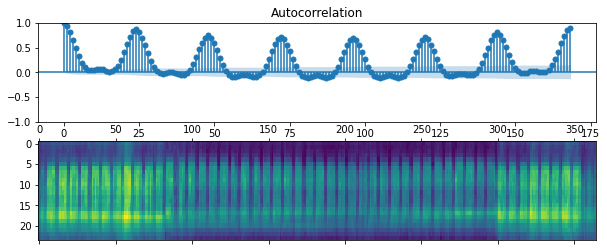

In [58]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
_ = sm.graphics.tsa.plot_acf(data['all'], lags=24*7, ax=ax[0])

y = data['all'].loc[data.index<'2019-01-13']
y = pd.concat([y, pd.Series(y.index.dayofyear, name='day', index=y.index),
               pd.Series(y.index.hour, name='hour', index=y.index)], axis=1)
y_mat = y.pivot(index='day', columns='hour', values='all').T
ax[1].matshow(y_mat, aspect='auto')



In [ ]:

from matplotlib import animation
from IPython.display import HTML

def ts_animation(y_te, y_hat, n_rows=50):
  "plot the first n_rows of the two y_te and y_hat matrices"
  fig, ax = plt.subplots(1);
  y_min = np.minimum(np.min(y_hat), np.min(y_te))
  y_max = np.maximum(np.max(y_hat), np.max(y_te))
  line1, = ax.plot(y_hat[0], lw=2);
  line2, = ax.plot(y_hat[0], lw=2);
  ax.set_ylim(y_min, y_max)
  n_sa = y_hat.shape[1]
  def animate(i):
    line1.set_data(np.arange(n_sa),y_te.values[i:i+n_sa]);
    line2.set_data(np.arange(n_sa),y_hat[i,:]);
    return (line1,line2) 

  def init():
    line1.set_data([], []);
    return (line1,)

  ani = animation.FuncAnimation(fig, animate, init_func=init, frames=n_rows, interval=100, 
                                save_count=50,blit=True)
  plt.close('all')
  #rc('animation', html='jshtml')
  return HTML(ani.to_jshtml())


In [84]:
def simple_smoothing(y, h=1, alpha=0.8): 
  y_hat = y.iloc[0]
  for y_i in y.values:
    y_hat = alpha*y_i + (1-alpha)*y_hat
  return np.tile(y_hat, h)


y_hat = []
for i in range(100):
  y_hat.append(simple_smoothing(data['all'].iloc[:1+i], 24))
y_hat = np.vstack(y_hat)

ts_animation(data['all'].iloc[:100], y_hat)


In [85]:
y_hat = []
for i in range(100):
  y_hat.append(simple_smoothing(data['all'].iloc[:1+i], 24, alpha=0.2))
y_hat = np.vstack(y_hat)

ts_animation(data['all'].iloc[:100], y_hat)

# Holt's linear trend

In [94]:
def holt_smoothing(y, h=1, alpha=0.8, beta=0.1): 
  l, l_past = y.iloc[0], y.iloc[0]
  b = 0
  for y_i in y.values:
    l = alpha*y_i + (1-alpha)*(l_past+b)
    b = beta*(l-l_past) + (1-beta)*b
    l_past = l

  return l + b*np.arange(h)

In [99]:
y_hat = []
for i in range(100):
  y_hat.append(holt_smoothing(data['all'].iloc[:1+i], 24, alpha=0.9, beta=0.05))
y_hat = np.vstack(y_hat)

ts_animation(data['all'].iloc[:100], y_hat)

In [119]:
def holt_winters(y, h=1, alpha=0.8, beta=0.1, gamma=0.1, m=24): 
  l, l_past = y.iloc[0], y.iloc[0]
  s = np.zeros(m)
  b = 0
  for y_i in y.values:
    s[-1] = gamma*(y_i-l-b) + (1-gamma)*s[-1]
    s = np.roll(s, -1)
    l = alpha*(y_i-s[0]) + (1-alpha)*(l_past+b)
    b = beta*(l-l_past) + (1-beta)*b
    l_past = l

  return l + b*np.arange(h) + s[:h]


In [127]:
y_hat = []
for i in range(600):
  y_hat.append(holt_winters(data['all'].iloc[:1+i], 24, alpha=0.9, beta=0.05, gamma=0.5))
y_hat = np.vstack(y_hat)



In [128]:
ts_animation(data['all'], y_hat, 500)

# New Section